# AIAp Miniproject 2

## Contents

- [Imports](#imports)

## Imports

In [76]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import models as keras_models
from tensorflow.keras import layers as keras_layers


## Configs

In [77]:
SEED = 42

## Dataset

### b) Citation and description

For our project we used the following data:

- **Title:** Architectural Heritage Elements Dataset
- **Subtitle:** 128 (creative commons) revised
- **Version:** 1
- **Publication Date:** 2017-02-20
- **Author:** Jose Llamas
- **Organization:** Fundación CARTIF
- **Source:** https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip
- **Media:** .jpg in .zip
- **Download:** 2024-03-26

The raw data was extracted with Windows. We then added it to our ["AIAp Miniproject 2"](https://gitlab.ost.ch/sylvester.homberger/aiap-miniproject-2) repository on the Gitlab instance of OST.

This dataset consists of 10437 RGB 64x64 jpg images classified in 11 categories:
- Altar: 828 images
- Apse: 505 images
- Bell tower: 1057 images
- Column: 1914 images
- Dome (inner): 589 images
- Dome (outer): 1175 images
- Flying buttress: 405 images
- Gargoyle (and Chimera): 1562 images
- Portal: 307 images
- Stained glass: 998 images
- Vault: 1097 images

As "flying buttress" and "portal" do not satisfy the minimal samples requirement of 500, we manually moved them out of our dataset into a separate folder. Our adjusted dataset therefore fulfils the requirements:
- RGB images of 9 classes
- Each has more than 500 samples and the total is 9725 images
- They have a resolution of 64x64 pixels

### c) Load and split data

In [79]:

data_folder = Path(os.getcwd()).parent / "data"
raw_folder = data_folder / "raw" / "Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"

raw_train_val_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="training"
)

raw_test_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="validation"
)

raw_training_data, raw_validation_data = keras_utils.split_dataset(raw_train_val_data, left_size=0.8, shuffle=True)

label_to_class = raw_train_val_data.class_names
class_to_label = dict(zip(label_to_class, range(len(label_to_class))))

## Exploratory data analysis

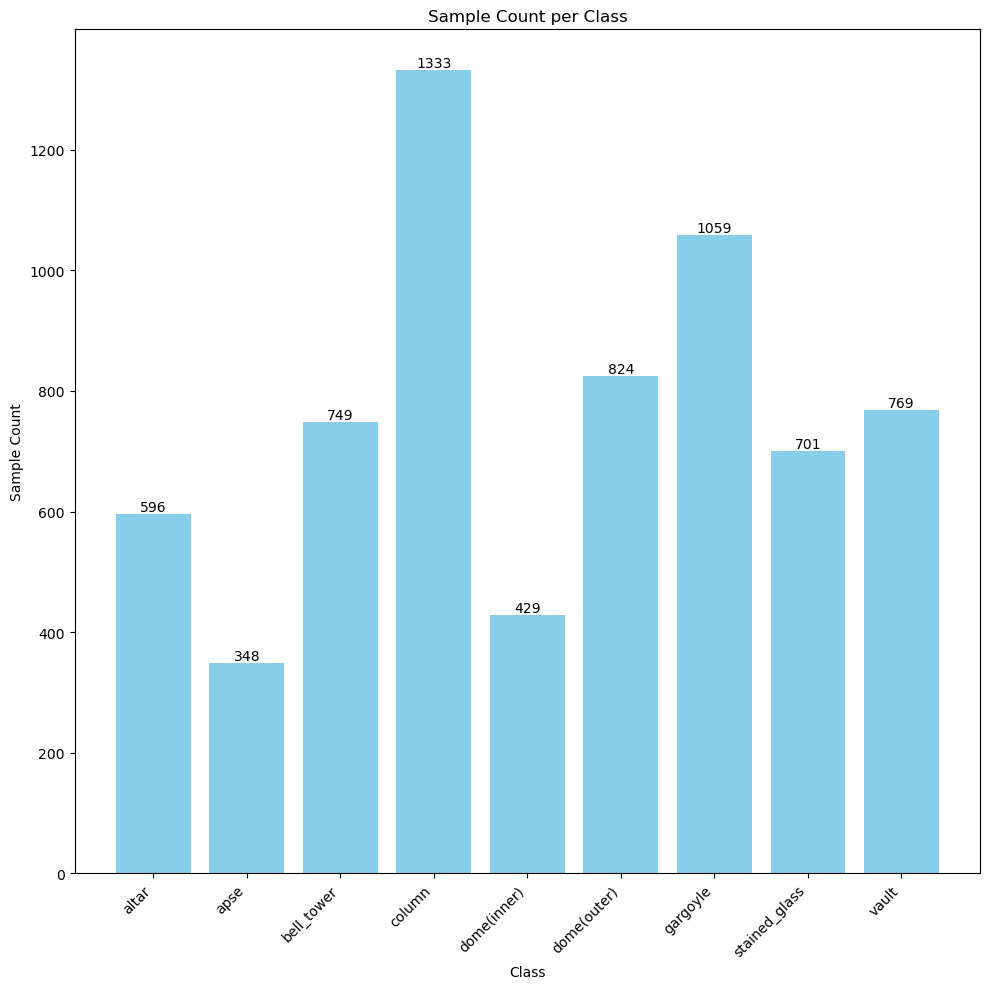

In [80]:
# Samples per class

class_counts = raw_train_val_data.reduce(
    initial_state=tf.zeros(len(label_to_class), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(label_to_class)))

class_counts_values = [count.numpy() for count in class_counts]

plt.figure(figsize=(10, 10))
bars = plt.bar(label_to_class, class_counts_values, color='skyblue')
plt.bar_label(bars, labels=class_counts_values, label_type='edge', color='black')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title('Sample Count per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


The dataset is not balanced. Classes need to be weighted for training.

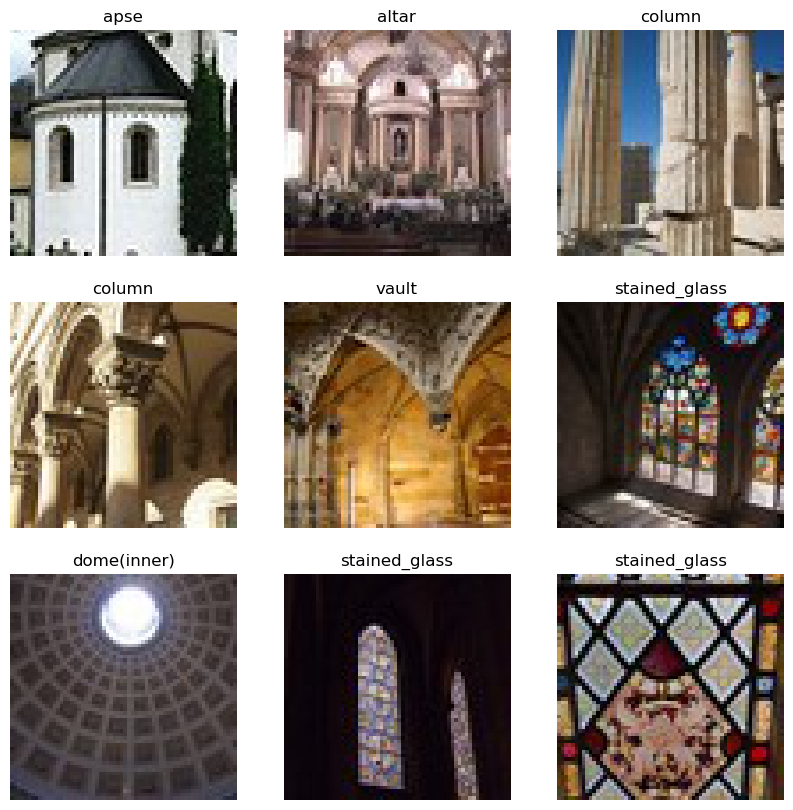

In [81]:
# Plot a few images

plt.figure(figsize=(10, 10))
for images, labels in raw_train_val_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label_to_class[labels[i]])
    plt.axis("off")

In [82]:
def scale_image_dataset(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

training_data = scale_image_dataset(raw_training_data)
validation_data = scale_image_dataset(raw_validation_data)

print("max: ", )

image_batch, labels_batch = next(iter(training_data))
first_image = image_batch[2]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


training_data.reduce(
    initial_state=tf.zeros(len(2), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(label_to_class)))



0.0 1.0


TypeError: object of type 'int' has no len()

## Architecture 1 (underfitting)

## Architecture 2 (overfitting)

In [83]:
underfitting_model = keras_models.Sequential()
underfitting_model.add(keras_layers.Conv2D(
    16, 3, padding='same', activation='relu', input_shape=(64, 64, 3)
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Conv2D(
    16, 2, padding='same', activation='relu'
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Flatten())


In [84]:
underfitting_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 16)        1040      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 4096)              0         
                                                                 
Total params: 1,488
Trainable params: 1,488
Non-train

In [85]:
underfitting_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = underfitting_model.fit(training_data, validation_data=validation_data, epochs=10)

Epoch 1/10
171/171 [==============================] - 3s 14ms/step - loss: 7.6768 - accuracy: 0.0588 - val_loss: 6.6644 - val_accuracy: 0.1204
Epoch 2/10
171/171 [==============================] - 2s 14ms/step - loss: 5.9492 - accuracy: 0.1377 - val_loss: 5.3976 - val_accuracy: 0.1446
Epoch 3/10
171/171 [==============================] - 3s 15ms/step - loss: 5.1582 - accuracy: 0.1866 - val_loss: 4.9454 - val_accuracy: 0.1858
Epoch 4/10
171/171 [==============================] - 2s 14ms/step - loss: 4.8360 - accuracy: 0.2147 - val_loss: 4.7185 - val_accuracy: 0.2151
Epoch 5/10
171/171 [==============================] - 2s 13ms/step - loss: 4.6580 - accuracy: 0.2312 - val_loss: 4.5804 - val_accuracy: 0.2291
Epoch 6/10
171/171 [==============================] - 2s 13ms/step - loss: 4.5444 - accuracy: 0.2376 - val_loss: 4.4886 - val_accuracy: 0.2327
Epoch 7/10
171/171 [==============================] - 2s 13ms/step - loss: 4.4661 - accuracy: 0.2422 - val_loss: 4.4243 - val_accuracy: 0.2401

## Architecture 2 (optimized)

## Quantification of the model performance

## Discussion